# Linear Regression

This project is for making a linear regression model for joint angle prediction

In [2]:
# Imports
from pathlib import Path
import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.decomposition import PCA

The dataset needs to be restructured for linear regression.
We don't need the gesture labels anymore, since our target is just joint angles.
We need to window the joint angles too. For simplicity we will average the 200ms window of joint angle data.

In [4]:
dataset = pickle.load(open('dataset_regression.pkl', 'rb'))

# Joint angle regression starts here

In [7]:
### Joint angles regression

import numpy as np

def reshape_data_windows_regression(X, y):
    """
    Converts:
        X: recordings x windows x features x channels
        y: recordings x windows x output_channels

    To:
        X_out: total_windows x (features * channels)
        y_out: total_windows x output_channels
    """

    X_list = list(X)
    y_list = list(y)

    X_windows = []
    y_windows = []

    for rec_idx, (rec_X, rec_y) in enumerate(zip(X_list, y_list)):
        rec_X = np.asarray(rec_X)
        rec_y = np.asarray(rec_y)

        # Skip recordings with no windows
        if rec_X.shape[0] == 0:
            continue

        # Sanity check
        if rec_X.shape[0] != rec_y.shape[0]:
            raise ValueError(
                f"Window mismatch in recording {rec_idx}: "
                f"X has {rec_X.shape[0]}, y has {rec_y.shape[0]}"
            )

        for w in range(rec_X.shape[0]):
            # Flatten features x channels → 938
            X_windows.append(rec_X[w].reshape(-1))
            y_windows.append(rec_y[w])  # shape: (18,)

    X_out = np.asarray(X_windows)
    y_out = np.asarray(y_windows)

    return X_out, y_out


dataset = pd.read_pickle('dataset_regression.pkl')

## RIDGE REGRESSION NO PCA


alpha: 1.832e-02   (1/10)
  Fold 1/10  Val R²: -5.747  Train R²: 0.559
  Fold 2/10  Val R²: 0.534  Train R²: 0.559
  Fold 3/10  Val R²: -1171.768  Train R²: 0.560
  Fold 4/10  Val R²: 0.540  Train R²: 0.560
  Fold 5/10  Val R²: 0.513  Train R²: 0.559
  Fold 6/10  Val R²: 0.506  Train R²: 0.560
  Fold 7/10  Val R²: 0.510  Train R²: 0.559
  Fold 8/10  Val R²: -7613.111  Train R²: 0.561
  Fold 9/10  Val R²: -2298.226  Train R²: 0.560
  Fold 10/10  Val R²: 0.541  Train R²: 0.559

alpha: 4.455e-02   (2/10)
  Fold 1/10  Val R²: -4.098  Train R²: 0.559
  Fold 2/10  Val R²: 0.534  Train R²: 0.558
  Fold 3/10  Val R²: -868.486  Train R²: 0.560
  Fold 4/10  Val R²: 0.540  Train R²: 0.560
  Fold 5/10  Val R²: 0.521  Train R²: 0.559
  Fold 6/10  Val R²: 0.512  Train R²: 0.560
  Fold 7/10  Val R²: 0.515  Train R²: 0.559
  Fold 8/10  Val R²: -6291.221  Train R²: 0.561
  Fold 9/10  Val R²: -2007.865  Train R²: 0.560
  Fold 10/10  Val R²: 0.541  Train R²: 0.559

alpha: 1.084e-01   (3/10)
  Fold 1/10 

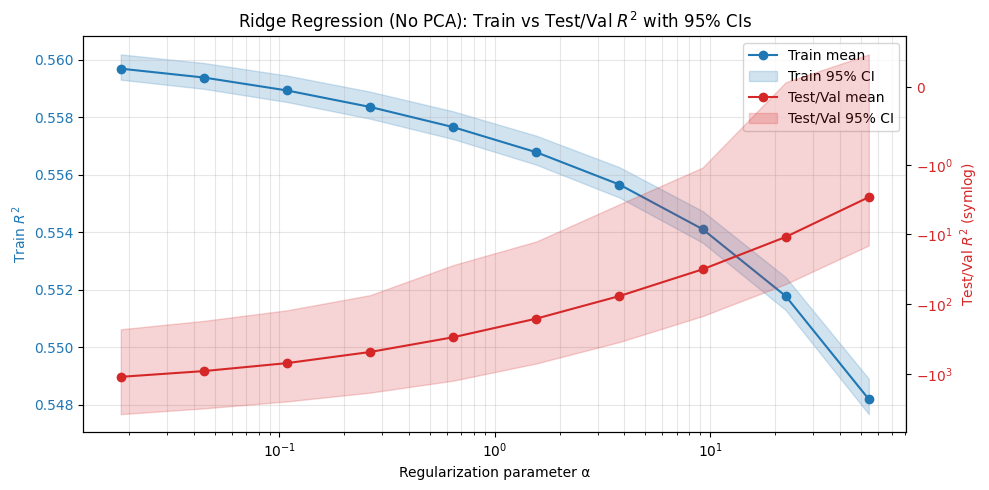

In [14]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import bootstrap
import numpy as np
import matplotlib.pyplot as plt

# Reshape data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    dataset["windows_feature"],
    dataset["joints"],
    test_size=0.2,
    random_state=42,
)
X_train_full, y_train_full = reshape_data_windows_regression(X_train_full, y_train_full)
X_test_full, y_test_full = reshape_data_windows_regression(X_test_full, y_test_full)

# Hyperparameters
n = 10
alphas = np.exp(np.linspace(-4, 4, n))
num_folds = 10

# Store ALL folds for ALL alphas
r2_val_nopca = np.zeros((n, num_folds), dtype=float)
r2_train_nopca = np.zeros((n, num_folds), dtype=float)

# Confidence interval per alpha (from the folds)
ci_lows = np.zeros(n, dtype=float)
ci_highs = np.zeros(n, dtype=float)
ci_lows_train = np.zeros(n, dtype=float)
ci_highs_train = np.zeros(n, dtype=float)
r2_val_mean = np.zeros(n, dtype=float)
r2_train_mean = np.zeros(n, dtype=float)

for j, alpha_j in enumerate(alphas):
    print(f"\nalpha: {alpha_j:.3e}   ({j+1}/{n})")

    for i in range(num_folds):
        # Split for validation (use different random_state each fold)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_full,
            y_train_full,
            test_size=0.2,
            shuffle=True,
            random_state=i,
        )

        # Fit scaler on TRAIN only, apply to train/val
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        reg = Ridge(alpha=alpha_j)
        reg.fit(X_tr_s, y_tr)

        y_val_pred = reg.predict(X_val_s)
        y_tr_pred = reg.predict(X_tr_s)

        r2_val = r2_score(y_val, y_val_pred, multioutput="uniform_average")
        r2_tr = r2_score(y_tr, y_tr_pred, multioutput="uniform_average")

        r2_val_nopca[j, i] = r2_val
        r2_train_nopca[j, i] = r2_tr

        print(f"  Fold {i+1}/{num_folds}  Val R²: {r2_val:.3f}  Train R²: {r2_tr:.3f}")

    # Mean + bootstrap CI across the folds for this alpha
    r2_vals = r2_val_nopca[j, :]
    r2_val_mean[j] = float(r2_vals.mean())
    r2_trains = r2_train_nopca[j, :]
    r2_train_mean[j] = float(r2_trains.mean())

    ci = bootstrap((r2_vals,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    ci_lows[j] = float(ci.low)
    ci_highs[j] = float(ci.high)

    ci_train = bootstrap((r2_trains,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    ci_lows_train[j] = float(ci_train.low)
    ci_highs_train[j] = float(ci_train.high)

print("\nShapes:")
print("r2_val_nopca:", r2_val_nopca.shape, " (n_alphas, num_folds)")
print("r2_train_nopca:", r2_train_nopca.shape, " (n_alphas, num_folds)")

# PLOTTING TRAINING AND TESTING DATA WITH CIs

fig, ax_train = plt.subplots(figsize=(10, 5))
ax_val = ax_train.twinx()

# Shared X (log scale for alpha)
ax_train.set_xscale("log")

# ---- Training (left axis, linear) ----
train_line = ax_train.plot(alphas, r2_train_mean, "o-", color="tab:blue", label="Train mean")[0]
ax_train.fill_between(alphas, ci_lows_train, ci_highs_train, color="tab:blue", alpha=0.20, label="Train 95% CI")
ax_train.set_ylabel("Train $R^2$", color="tab:blue")
ax_train.tick_params(axis="y", labelcolor="tab:blue")

# ---- Testing/Validation (right axis, symlog to handle huge negatives) ----
val_line = ax_val.plot(alphas, r2_val_mean, "o-", color="tab:red", label="Test/Val mean")[0]
ax_val.fill_between(alphas, ci_lows, ci_highs, color="tab:red", alpha=0.20, label="Test/Val 95% CI")

# symlog works with negative + positive values (unlike log)
ax_val.set_yscale("symlog", linthresh=1.0, base=10)
ax_val.set_ylabel("Test/Val $R^2$ (symlog)", color="tab:red")
ax_val.tick_params(axis="y", labelcolor="tab:red")

# ---- Labels / title / legend ----
ax_train.set_xlabel("Regularization parameter α")
ax_train.set_title("Ridge Regression (No PCA): Train vs Test/Val $R^2$ with 95% CIs")
ax_train.grid(True, which="both", alpha=0.3)

# Combine legends from both axes
h1, l1 = ax_train.get_legend_handles_labels()
h2, l2 = ax_val.get_legend_handles_labels()
ax_train.legend(h1 + h2, l1 + l2, loc="best")

plt.tight_layout()
plt.show()

## THERE IS A NEED TO KEEP GOING WITH MORE REGULARIZATION


alpha: 1.000e-04   (1/20)
  Fold 1/5  Val R²: -11.885  Train R²: 0.559
  Fold 2/5  Val R²: 0.533  Train R²: 0.559
  Fold 3/5  Val R²: -1814.949  Train R²: 0.560
  Fold 4/5  Val R²: 0.541  Train R²: 0.560
  Fold 5/5  Val R²: 0.493  Train R²: 0.559

alpha: 2.637e-04   (2/20)
  Fold 1/5  Val R²: -11.634  Train R²: 0.559
  Fold 2/5  Val R²: 0.533  Train R²: 0.559
  Fold 3/5  Val R²: -1802.961  Train R²: 0.560
  Fold 4/5  Val R²: 0.541  Train R²: 0.560
  Fold 5/5  Val R²: 0.494  Train R²: 0.559

alpha: 6.952e-04   (3/20)
  Fold 1/5  Val R²: -11.057  Train R²: 0.559
  Fold 2/5  Val R²: 0.533  Train R²: 0.559
  Fold 3/5  Val R²: -1772.678  Train R²: 0.560
  Fold 4/5  Val R²: 0.541  Train R²: 0.560
  Fold 5/5  Val R²: 0.495  Train R²: 0.559

alpha: 1.833e-03   (4/20)
  Fold 1/5  Val R²: -9.937  Train R²: 0.559
  Fold 2/5  Val R²: 0.533  Train R²: 0.559
  Fold 3/5  Val R²: -1700.690  Train R²: 0.560
  Fold 4/5  Val R²: 0.541  Train R²: 0.560
  Fold 5/5  Val R²: 0.497  Train R²: 0.559

alpha: 4

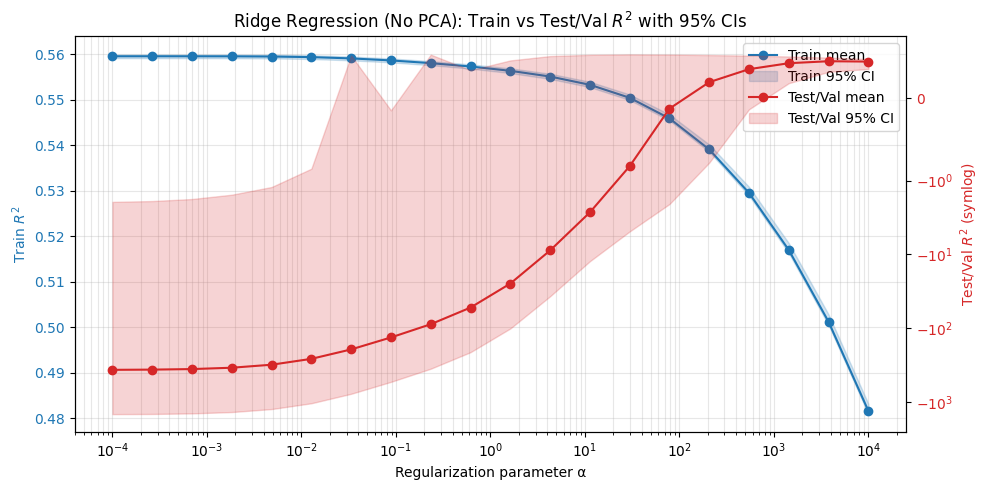

In [15]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import bootstrap
import numpy as np
import matplotlib.pyplot as plt

# Reshape data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    dataset["windows_feature"],
    dataset["joints"],
    test_size=0.2,
    random_state=42,
)
X_train_full, y_train_full = reshape_data_windows_regression(X_train_full, y_train_full)
X_test_full, y_test_full = reshape_data_windows_regression(X_test_full, y_test_full)

# Hyperparameters
n = 20
alphas = np.exp(np.linspace(-4*np.log(10), 4*np.log(10), n))  # 1e-4 ... 1e4
num_folds = 5

# Store ALL folds for ALL alphas
r2_val_nopca = np.zeros((n, num_folds), dtype=float)
r2_train_nopca = np.zeros((n, num_folds), dtype=float)

# Confidence interval per alpha (from the folds)
ci_lows = np.zeros(n, dtype=float)
ci_highs = np.zeros(n, dtype=float)
ci_lows_train = np.zeros(n, dtype=float)
ci_highs_train = np.zeros(n, dtype=float)
r2_val_mean = np.zeros(n, dtype=float)
r2_train_mean = np.zeros(n, dtype=float)

for j, alpha_j in enumerate(alphas):
    print(f"\nalpha: {alpha_j:.3e}   ({j+1}/{n})")

    for i in range(num_folds):
        # Split for validation (use different random_state each fold)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_full,
            y_train_full,
            test_size=0.2,
            shuffle=True,
            random_state=i,
        )

        # Fit scaler on TRAIN only, apply to train/val
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        reg = Ridge(alpha=alpha_j)
        reg.fit(X_tr_s, y_tr)

        y_val_pred = reg.predict(X_val_s)
        y_tr_pred = reg.predict(X_tr_s)

        r2_val = r2_score(y_val, y_val_pred, multioutput="uniform_average")
        r2_tr = r2_score(y_tr, y_tr_pred, multioutput="uniform_average")

        r2_val_nopca[j, i] = r2_val
        r2_train_nopca[j, i] = r2_tr

        print(f"  Fold {i+1}/{num_folds}  Val R²: {r2_val:.3f}  Train R²: {r2_tr:.3f}")

    # Mean + bootstrap CI across the folds for this alpha
    r2_vals = r2_val_nopca[j, :]
    r2_val_mean[j] = float(r2_vals.mean())
    r2_trains = r2_train_nopca[j, :]
    r2_train_mean[j] = float(r2_trains.mean())

    ci = bootstrap((r2_vals,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    ci_lows[j] = float(ci.low)
    ci_highs[j] = float(ci.high)

    ci_train = bootstrap((r2_trains,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    ci_lows_train[j] = float(ci_train.low)
    ci_highs_train[j] = float(ci_train.high)

print("\nShapes:")
print("r2_val_nopca:", r2_val_nopca.shape, " (n_alphas, num_folds)")
print("r2_train_nopca:", r2_train_nopca.shape, " (n_alphas, num_folds)")

# PLOTTING TRAINING AND TESTING DATA WITH CIs

fig, ax_train = plt.subplots(figsize=(10, 5))
ax_val = ax_train.twinx()

# Shared X (log scale for alpha)
ax_train.set_xscale("log")

# ---- Training (left axis, linear) ----
train_line = ax_train.plot(alphas, r2_train_mean, "o-", color="tab:blue", label="Train mean")[0]
ax_train.fill_between(alphas, ci_lows_train, ci_highs_train, color="tab:blue", alpha=0.20, label="Train 95% CI")
ax_train.set_ylabel("Train $R^2$", color="tab:blue")
ax_train.tick_params(axis="y", labelcolor="tab:blue")

# ---- Testing/Validation (right axis, symlog to handle huge negatives) ----
val_line = ax_val.plot(alphas, r2_val_mean, "o-", color="tab:red", label="Test/Val mean")[0]
ax_val.fill_between(alphas, ci_lows, ci_highs, color="tab:red", alpha=0.20, label="Test/Val 95% CI")

# symlog works with negative + positive values (unlike log)
ax_val.set_yscale("symlog", linthresh=1.0, base=10)
ax_val.set_ylabel("Test/Val $R^2$ (symlog)", color="tab:red")
ax_val.tick_params(axis="y", labelcolor="tab:red")

# ---- Labels / title / legend ----
ax_train.set_xlabel("Regularization parameter α")
ax_train.set_title("Ridge Regression (No PCA): Train vs Test/Val $R^2$ with 95% CIs")
ax_train.grid(True, which="both", alpha=0.3)

# Combine legends from both axes
h1, l1 = ax_train.get_legend_handles_labels()
h2, l2 = ax_val.get_legend_handles_labels()
ax_train.legend(h1 + h2, l1 + l2, loc="best")

plt.tight_layout()
plt.show()

This helped. Trying to zoom in on that range past 10^2 and using the same scale.

In [17]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import bootstrap
import numpy as np
import matplotlib.pyplot as plt

# Reshape data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    dataset["windows_feature"],
    dataset["joints"],
    test_size=0.2,
    random_state=42,
)
X_train_full, y_train_full = reshape_data_windows_regression(X_train_full, y_train_full)
X_test_full, y_test_full = reshape_data_windows_regression(X_test_full, y_test_full)

# Hyperparameters
n = 10
alphas = np.exp(np.linspace(3*np.log(10), 5*np.log(10), n))  # 1e3 ... 1e5
num_folds = 5

# Store ALL folds for ALL alphas
r2_val_nopca = np.zeros((n, num_folds), dtype=float)
r2_train_nopca = np.zeros((n, num_folds), dtype=float)

# Confidence interval per alpha (from the folds)
ci_lows = np.zeros(n, dtype=float)
ci_highs = np.zeros(n, dtype=float)
ci_lows_train = np.zeros(n, dtype=float)
ci_highs_train = np.zeros(n, dtype=float)
r2_val_mean = np.zeros(n, dtype=float)
r2_train_mean = np.zeros(n, dtype=float)

for j, alpha_j in enumerate(alphas):
    print(f"\nalpha: {alpha_j:.3e}   ({j+1}/{n})")

    for i in range(num_folds):
        # Split for validation (use different random_state each fold)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_full,
            y_train_full,
            test_size=0.5,
            shuffle=True,
            random_state=i,
        )

        # Fit scaler on TRAIN only, apply to train/val
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        reg = Ridge(alpha=alpha_j)
        reg.fit(X_tr_s, y_tr)

        y_val_pred = reg.predict(X_val_s)
        y_tr_pred = reg.predict(X_tr_s)

        r2_val = r2_score(y_val, y_val_pred, multioutput="uniform_average")
        r2_tr = r2_score(y_tr, y_tr_pred, multioutput="uniform_average")

        r2_val_nopca[j, i] = r2_val
        r2_train_nopca[j, i] = r2_tr

        print(f"  Fold {i+1}/{num_folds}  Val R²: {r2_val:.3f}  Train R²: {r2_tr:.3f}")

    # Mean + bootstrap CI across the folds for this alpha
    r2_vals = r2_val_nopca[j, :]
    r2_val_mean[j] = float(r2_vals.mean())
    r2_trains = r2_train_nopca[j, :]
    r2_train_mean[j] = float(r2_trains.mean())

    ci = bootstrap((r2_vals,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    ci_lows[j] = float(ci.low)
    ci_highs[j] = float(ci.high)

    ci_train = bootstrap((r2_trains,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    ci_lows_train[j] = float(ci_train.low)
    ci_highs_train[j] = float(ci_train.high)

print("\nShapes:")
print("r2_val_nopca:", r2_val_nopca.shape, " (n_alphas, num_folds)")
print("r2_train_nopca:", r2_train_nopca.shape, " (n_alphas, num_folds)")


alpha: 1.000e+03   (1/10)
  Fold 1/5  Val R²: 0.519  Train R²: 0.542
  Fold 2/5  Val R²: 0.402  Train R²: 0.543
  Fold 3/5  Val R²: 0.525  Train R²: 0.540
  Fold 4/5  Val R²: 0.387  Train R²: 0.543
  Fold 5/5  Val R²: -0.620  Train R²: 0.549

alpha: 1.668e+03   (2/10)
  Fold 1/5  Val R²: 0.513  Train R²: 0.531
  Fold 2/5  Val R²: 0.439  Train R²: 0.532
  Fold 3/5  Val R²: 0.517  Train R²: 0.530
  Fold 4/5  Val R²: 0.430  Train R²: 0.533
  Fold 5/5  Val R²: -0.214  Train R²: 0.538

alpha: 2.783e+03   (3/10)
  Fold 1/5  Val R²: 0.504  Train R²: 0.519
  Fold 2/5  Val R²: 0.453  Train R²: 0.520
  Fold 3/5  Val R²: 0.508  Train R²: 0.518
  Fold 4/5  Val R²: 0.445  Train R²: 0.520
  Fold 5/5  Val R²: 0.036  Train R²: 0.526

alpha: 4.642e+03   (4/10)
  Fold 1/5  Val R²: 0.494  Train R²: 0.505
  Fold 2/5  Val R²: 0.452  Train R²: 0.506
  Fold 3/5  Val R²: 0.496  Train R²: 0.504
  Fold 4/5  Val R²: 0.445  Train R²: 0.506
  Fold 5/5  Val R²: 0.184  Train R²: 0.512

alpha: 7.743e+03   (5/10)
  F

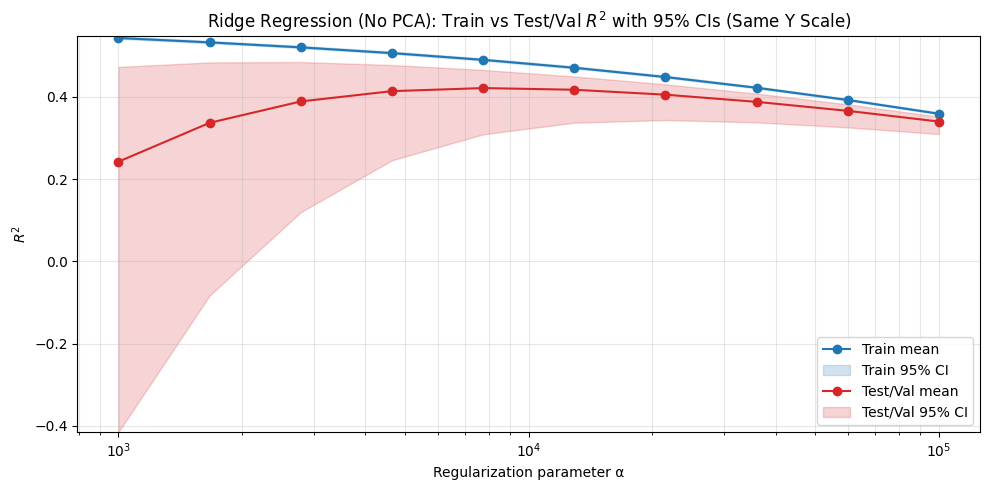

In [16]:
# PLOTTING TRAINING AND TESTING DATA WITH CIs

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xscale("log")
ax.plot(alphas, r2_train_mean, "o-", color="tab:blue", label="Train mean")
ax.fill_between(alphas, ci_lows_train, ci_highs_train, color="tab:blue", alpha=0.20, label="Train 95% CI")
ax.plot(alphas, r2_val_mean, "o-", color="tab:red", label="Test/Val mean")
ax.fill_between(alphas, ci_lows, ci_highs, color="tab:red", alpha=0.20, label="Test/Val 95% CI")
y_min = float(min(ci_lows_train.min(), ci_lows.min()))
y_max = float(max(ci_highs_train.max(), ci_highs.max()))
ax.set_ylim(y_min, y_max)
ax.set_xlabel("Regularization parameter α")
ax.set_ylabel("$R^2$")
ax.set_title("Ridge Regression (No PCA): Train vs Test/Val $R^2$ with 95% CIs (Same Y Scale)")
ax.grid(True, which="both", alpha=0.3)
ax.legend(loc="best")
plt.tight_layout()
plt.show()

# PER JOINT

In [22]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Reshape data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    dataset["windows_feature"],
    dataset["joints"],
    test_size=0.2,
    random_state=42,
)
X_train_full, y_train_full = reshape_data_windows_regression(X_train_full, y_train_full)
X_test_full, y_test_full = reshape_data_windows_regression(X_test_full, y_test_full)

# Hyperparameters
n = 10
alphas = np.exp(np.linspace(3 * np.log(10), 5 * np.log(10), n))  # 1e3 ... 1e5
num_folds = 5

num_joints = int(y_train_full.shape[1])  # should be 18

# Store per-joint R^2 for all folds and alphas
# Shapes: (n_alphas, num_folds, num_joints)
r2_val_joint = np.zeros((n, num_folds, num_joints), dtype=float)
r2_train_joint = np.zeros((n, num_folds, num_joints), dtype=float)

for j, alpha_j in enumerate(alphas):
    print(f"\nalpha: {alpha_j:.3e}   ({j+1}/{n})")

    for i in range(num_folds):
        # Split for validation (use different random_state each fold)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_full,
            y_train_full,
            test_size=0.5,
            shuffle=True,
            random_state=i,
        )

        # Fit scaler on TRAIN only, apply to train/val
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        reg = Ridge(alpha=alpha_j)
        reg.fit(X_tr_s, y_tr)

        y_val_pred = reg.predict(X_val_s)
        y_tr_pred = reg.predict(X_tr_s)

        # Per-joint R^2 (18 outputs)
        r2_val_per_joint = r2_score(y_val, y_val_pred, multioutput="raw_values")
        r2_tr_per_joint = r2_score(y_tr, y_tr_pred, multioutput="raw_values")

        r2_val_joint[j, i, :] = r2_val_per_joint
        r2_train_joint[j, i, :] = r2_tr_per_joint

        print(
            f"  Fold {i+1}/{num_folds}  "
            f"Val mean R²: {float(np.mean(r2_val_per_joint)):.3f}  "
            f"Train mean R²: {float(np.mean(r2_tr_per_joint)):.3f}"
        )

# Mean across folds -> (n_alphas, num_joints)
r2_val_joint_mean = r2_val_joint.mean(axis=1)
r2_train_joint_mean = r2_train_joint.mean(axis=1)

print("\nShapes:")
print("r2_val_joint:", r2_val_joint.shape, " (n_alphas, num_folds, num_joints)")
print("r2_train_joint:", r2_train_joint.shape, " (n_alphas, num_folds, num_joints)")
print("r2_val_joint_mean:", r2_val_joint_mean.shape, " (n_alphas, num_joints)")
print("r2_train_joint_mean:", r2_train_joint_mean.shape, " (n_alphas, num_joints)")


alpha: 1.000e+03   (1/10)
  Fold 1/5  Val mean R²: 0.519  Train mean R²: 0.542
  Fold 2/5  Val mean R²: 0.402  Train mean R²: 0.543
  Fold 3/5  Val mean R²: 0.525  Train mean R²: 0.540
  Fold 4/5  Val mean R²: 0.387  Train mean R²: 0.543
  Fold 5/5  Val mean R²: -0.620  Train mean R²: 0.549

alpha: 1.668e+03   (2/10)
  Fold 1/5  Val mean R²: 0.513  Train mean R²: 0.531
  Fold 2/5  Val mean R²: 0.439  Train mean R²: 0.532
  Fold 3/5  Val mean R²: 0.517  Train mean R²: 0.530
  Fold 4/5  Val mean R²: 0.430  Train mean R²: 0.533
  Fold 5/5  Val mean R²: -0.214  Train mean R²: 0.538

alpha: 2.783e+03   (3/10)
  Fold 1/5  Val mean R²: 0.504  Train mean R²: 0.519
  Fold 2/5  Val mean R²: 0.453  Train mean R²: 0.520
  Fold 3/5  Val mean R²: 0.508  Train mean R²: 0.518
  Fold 4/5  Val mean R²: 0.445  Train mean R²: 0.520
  Fold 5/5  Val mean R²: 0.036  Train mean R²: 0.526

alpha: 4.642e+03   (4/10)
  Fold 1/5  Val mean R²: 0.494  Train mean R²: 0.505
  Fold 2/5  Val mean R²: 0.452  Train mean

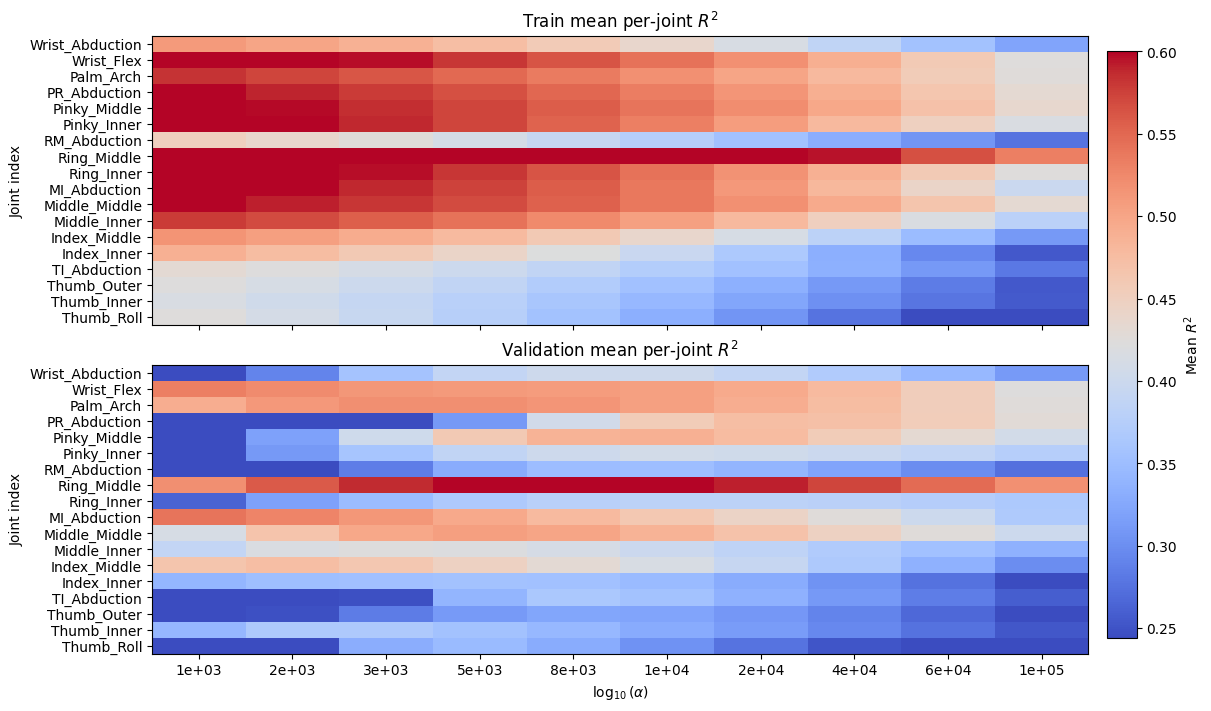

In [31]:
# ---- One readable figure: 2 heatmaps (Train + Val) ----
joint_names = [
    "Thumb_Roll", "Thumb_Inner", "Thumb_Outer", "TI_Abduction",
    "Index_Inner", "Index_Middle", "Middle_Inner", "Middle_Middle",
    "MI_Abduction", "Ring_Inner", "Ring_Middle", "RM_Abduction",
    "Pinky_Inner", "Pinky_Middle", "PR_Abduction", "Palm_Arch",
    "Wrist_Flex", "Wrist_Abduction",
]
log_a = np.log10(alphas)

# Build edges for pcolormesh
d = np.diff(log_a)
if len(d) == 0:
    raise ValueError("Need at least 2 alphas to plot a heatmap")

left_edge = log_a[0] - d[0] / 2
right_edge = log_a[-1] + d[-1] / 2
x_edges = np.concatenate(([left_edge], (log_a[:-1] + log_a[1:]) / 2, [right_edge]))
y_edges = np.arange(num_joints + 1) - 0.5

# Shared color scaling across both heatmaps (keeps figure comparable)
combined = np.concatenate([r2_train_joint_mean.ravel(), r2_val_joint_mean.ravel()])
vmin = float(np.nanpercentile(combined, 5))
vmax = float(np.nanpercentile(combined, 95))
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
    vmin, vmax = float(np.nanmin(combined)), float(np.nanmax(combined))

# Center colormap at 0 if it lies in range (negative R^2 stands out)
if vmin < 0 < vmax:
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
else:
    norm = None

fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, constrained_layout=True
)
cmap = "coolwarm"

m0 = axes[0].pcolormesh(
    x_edges,
    y_edges,
    r2_train_joint_mean.T,  # (num_joints, n_alphas)
    shading="auto",
    cmap=cmap,
    norm=norm,
    vmin=None if norm is not None else vmin,
    vmax=None if norm is not None else vmax,
)
axes[0].set_title("Train mean per-joint $R^2$")
axes[0].set_ylabel("Joint index")

m1 = axes[1].pcolormesh(
    x_edges,
    y_edges,
    r2_val_joint_mean.T,
    shading="auto",
    cmap=cmap,
    norm=norm,
    vmin=None if norm is not None else vmin,
    vmax=None if norm is not None else vmax,
)
axes[1].set_title("Validation mean per-joint $R^2$")
axes[1].set_ylabel("Joint index")
axes[1].set_xlabel(r"$\log_{10}(\alpha)$")

# Label x ticks at each alpha with scientific notation
axes[1].set_xticks(log_a)
axes[1].set_xticklabels([f"{a:.0e}" for a in alphas])

for ax in axes:
    ax.set_yticks(np.arange(num_joints))      # tick locations: 0..17
    ax.set_yticklabels(joint_names)           # tick labels: your joint names
    ax.set_ylim(-0.5, num_joints - 0.5)

cbar = fig.colorbar(m1, ax=axes, shrink=0.95, pad=0.02)
cbar.set_label("Mean $R^2$")

plt.show()

## KERNEL RIDGE WITH RBF

In [33]:
from sklearn.kernel_ridge import KernelRidge

print("\nKernel Ridge Regression with RBF kernel (full):")
gammas = [0.001, 0.01, 0.1, 1.0]
alphas_kernel = [0.1, 1.0, 10.0, 100.0]

results_rbf = []

# Scale data first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)

for gamma in gammas:
    for alpha_k in alphas_kernel:
        print(f'gamma: {gamma}, alpha: {alpha_k}')
        
        # Split for validation
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_scaled, y_train_full,
            test_size=0.5,
            random_state=42
        )
        
        krr = KernelRidge(alpha=alpha_k, kernel='rbf', gamma=gamma)
        krr.fit(X_tr, y_tr)
        
        y_val_pred = krr.predict(X_val)
        y_tr_pred = krr.predict(X_tr)
        
        r2_val = r2_score(y_val, y_val_pred, multioutput='uniform_average')
        r2_train = r2_score(y_tr, y_tr_pred, multioutput='uniform_average')
        
        results_rbf.append({
            'gamma': gamma,
            'alpha': alpha_k,
            'r2_val': r2_val,
            'r2_train': r2_train
        })
        
        print(f'  Val R²: {r2_val:.3f}, Train R²: {r2_train:.3f}')

best_rbf = max(results_rbf, key=lambda x: x['r2_val'])
print(f"\nBest RBF: gamma={best_rbf['gamma']}, alpha={best_rbf['alpha']}, R²={best_rbf['r2_val']:.3f}")


Kernel Ridge Regression with RBF kernel (full):
gamma: 0.001, alpha: 0.1
  Val R²: 0.763, Train R²: 0.875
gamma: 0.001, alpha: 1.0
  Val R²: 0.679, Train R²: 0.732
gamma: 0.001, alpha: 10.0
  Val R²: 0.534, Train R²: 0.558
gamma: 0.001, alpha: 100.0
  Val R²: 0.291, Train R²: 0.305
gamma: 0.01, alpha: 0.1
  Val R²: 0.554, Train R²: 0.994
gamma: 0.01, alpha: 1.0
  Val R²: 0.420, Train R²: 0.829
gamma: 0.01, alpha: 10.0
  Val R²: -0.079, Train R²: 0.098
gamma: 0.01, alpha: 100.0
  Val R²: -1.100, Train R²: -1.065
gamma: 0.1, alpha: 0.1
  Val R²: -3.734, Train R²: 0.961
gamma: 0.1, alpha: 1.0
  Val R²: -3.741, Train R²: -0.190
gamma: 0.1, alpha: 10.0
  Val R²: -3.747, Train R²: -2.939
gamma: 0.1, alpha: 100.0
  Val R²: -3.748, Train R²: -3.673
gamma: 1.0, alpha: 0.1
  Val R²: -3.749, Train R²: 0.961
gamma: 1.0, alpha: 1.0
  Val R²: -3.749, Train R²: -0.192
gamma: 1.0, alpha: 10.0
  Val R²: -3.749, Train R²: -2.940
gamma: 1.0, alpha: 100.0
  Val R²: -3.749, Train R²: -3.673

Best RBF: gam

In [34]:
#SAVE RESULTS RBF TO PICKLE
import pickle
with open('krr_rbf_results.pkl', 'wb') as f:
    pickle.dump(results_rbf, f)

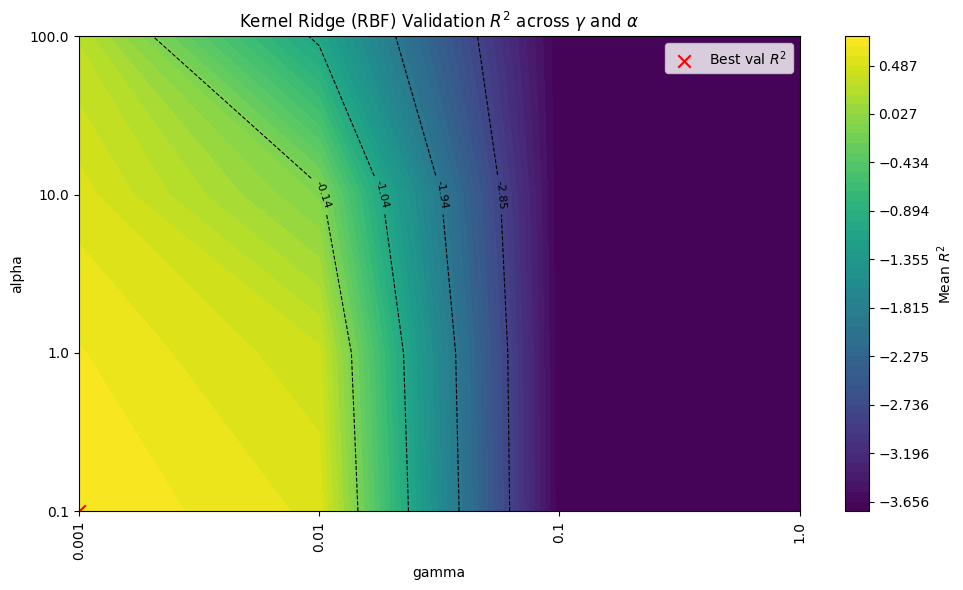

In [35]:
# ---- Contour plot for Kernel Ridge (RBF) results ----
# Expects: results_rbf (list of dicts), gammas (list), alphas_kernel (list)

import numpy as np
import matplotlib.pyplot as plt

# Build validation R^2 grid: rows=alpha, cols=gamma
r2_val_grid = np.full((len(alphas_kernel), len(gammas)), np.nan, dtype=float)
r2_train_grid = np.full((len(alphas_kernel), len(gammas)), np.nan, dtype=float)

gamma_to_j = {g: j for j, g in enumerate(gammas)}
alpha_to_i = {a: i for i, a in enumerate(alphas_kernel)}

for row in results_rbf:
    i = alpha_to_i[row["alpha"]]
    j = gamma_to_j[row["gamma"]]
    r2_val_grid[i, j] = row["r2_val"]
    r2_train_grid[i, j] = row["r2_train"]

XX, YY = np.meshgrid(np.arange(len(gammas)), np.arange(len(alphas_kernel)))

# Choose which surface to plot
Z = r2_val_grid  # <- change to r2_train_grid if you want train instead

vmin = float(np.nanmin(Z))
vmax = float(np.nanmax(Z))
levels_f = np.linspace(vmin, vmax, 50)

plt.figure(figsize=(10, 6))
plt.contourf(XX, YY, Z, levels=levels_f, cmap="viridis")
plt.colorbar(label="Mean $R^2$")

# Contour lines (auto-chosen, 6 levels)
levels_c = np.linspace(vmin, vmax, 6)
CS = plt.contour(XX, YY, Z, levels=levels_c, colors="k", linewidths=0.8)
plt.clabel(CS, CS.levels, inline=True, fontsize=8, fmt="%.2f")

plt.title("Kernel Ridge (RBF) Validation $R^2$ across $\\gamma$ and $\\alpha$")
plt.xlabel("gamma")
plt.ylabel("alpha")

plt.xticks(np.arange(len(gammas)), [str(g) for g in gammas], rotation=90)
plt.yticks(np.arange(len(alphas_kernel)), [str(a) for a in alphas_kernel])

# Mark best point (highest validation R^2)
best_idx = np.nanargmax(r2_val_grid)
best_i, best_j = np.unravel_index(best_idx, r2_val_grid.shape)
plt.scatter(best_j, best_i, c="red", s=80, marker="x", label="Best val $R^2$")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Clearly we need to expand the graph

In [37]:
from sklearn.kernel_ridge import KernelRidge

print("\nKernel Ridge Regression with RBF kernel (full):")
gammas = [0.000001, 0.00001, 0.0001, 0.001]
alphas_kernel = [0.001, 0.01, 0.1, 1.0]

results_rbf = []

# Scale data first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)

for gamma in gammas:
    for alpha_k in alphas_kernel:
        print(f'gamma: {gamma}, alpha: {alpha_k}')
        
        # Split for validation
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_scaled, y_train_full,
            test_size=0.5,
            random_state=42
        )
        
        krr = KernelRidge(alpha=alpha_k, kernel='rbf', gamma=gamma)
        krr.fit(X_tr, y_tr)
        
        y_val_pred = krr.predict(X_val)
        y_tr_pred = krr.predict(X_tr)
        
        r2_val = r2_score(y_val, y_val_pred, multioutput='uniform_average')
        r2_train = r2_score(y_tr, y_tr_pred, multioutput='uniform_average')
        
        results_rbf.append({
            'gamma': gamma,
            'alpha': alpha_k,
            'r2_val': r2_val,
            'r2_train': r2_train
        })
        
        print(f'  Val R²: {r2_val:.3f}, Train R²: {r2_train:.3f}')

best_rbf = max(results_rbf, key=lambda x: x['r2_val'])
print(f"\nBest RBF: gamma={best_rbf['gamma']}, alpha={best_rbf['alpha']}, R²={best_rbf['r2_val']:.3f}")


Kernel Ridge Regression with RBF kernel (full):
gamma: 1e-06, alpha: 0.001
  Val R²: 0.528, Train R²: 0.562
gamma: 1e-06, alpha: 0.01
  Val R²: 0.495, Train R²: 0.505
gamma: 1e-06, alpha: 0.1
  Val R²: 0.402, Train R²: 0.403
gamma: 1e-06, alpha: 1.0
  Val R²: 0.239, Train R²: 0.237
gamma: 1e-05, alpha: 0.001
  Val R²: 0.610, Train R²: 0.654
gamma: 1e-05, alpha: 0.01
  Val R²: 0.563, Train R²: 0.584
gamma: 1e-05, alpha: 0.1
  Val R²: 0.507, Train R²: 0.514
gamma: 1e-05, alpha: 1.0
  Val R²: 0.406, Train R²: 0.407
gamma: 0.0001, alpha: 0.001
  Val R²: 0.745, Train R²: 0.861
gamma: 0.0001, alpha: 0.01
  Val R²: 0.692, Train R²: 0.745
gamma: 0.0001, alpha: 0.1
  Val R²: 0.618, Train R²: 0.643
gamma: 0.0001, alpha: 1.0
  Val R²: 0.535, Train R²: 0.546
gamma: 0.001, alpha: 0.001
  Val R²: 0.796, Train R²: 0.999
gamma: 0.001, alpha: 0.01
  Val R²: 0.798, Train R²: 0.975
gamma: 0.001, alpha: 0.1
  Val R²: 0.763, Train R²: 0.875
gamma: 0.001, alpha: 1.0
  Val R²: 0.679, Train R²: 0.732

Best R

In [38]:
# SAVE THE RESULTS RBF TO PICKLE
import pickle
with open('krr_rbf_results_fine.pkl', 'wb') as f:
    pickle.dump(results_rbf, f)

## PLOT 

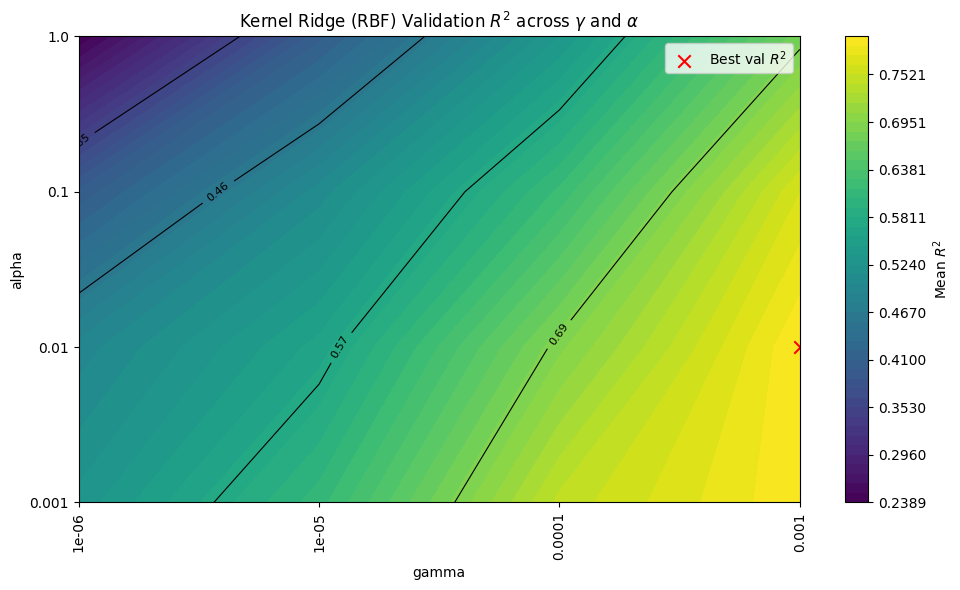

In [39]:
# ---- Contour plot for Kernel Ridge (RBF) results ----
# Expects: results_rbf (list of dicts), gammas (list), alphas_kernel (list)

import numpy as np
import matplotlib.pyplot as plt

# Build validation R^2 grid: rows=alpha, cols=gamma
r2_val_grid = np.full((len(alphas_kernel), len(gammas)), np.nan, dtype=float)
r2_train_grid = np.full((len(alphas_kernel), len(gammas)), np.nan, dtype=float)

gamma_to_j = {g: j for j, g in enumerate(gammas)}
alpha_to_i = {a: i for i, a in enumerate(alphas_kernel)}

for row in results_rbf:
    i = alpha_to_i[row["alpha"]]
    j = gamma_to_j[row["gamma"]]
    r2_val_grid[i, j] = row["r2_val"]
    r2_train_grid[i, j] = row["r2_train"]

XX, YY = np.meshgrid(np.arange(len(gammas)), np.arange(len(alphas_kernel)))

# Choose which surface to plot
Z = r2_val_grid  # <- change to r2_train_grid if you want train instead

vmin = float(np.nanmin(Z))
vmax = float(np.nanmax(Z))
levels_f = np.linspace(vmin, vmax, 50)

plt.figure(figsize=(10, 6))
plt.contourf(XX, YY, Z, levels=levels_f, cmap="viridis")
plt.colorbar(label="Mean $R^2$")

# Contour lines (auto-chosen, 6 levels)
levels_c = np.linspace(vmin, vmax, 6)
CS = plt.contour(XX, YY, Z, levels=levels_c, colors="k", linewidths=0.8)
plt.clabel(CS, CS.levels, inline=True, fontsize=8, fmt="%.2f")

plt.title("Kernel Ridge (RBF) Validation $R^2$ across $\\gamma$ and $\\alpha$")
plt.xlabel("gamma")
plt.ylabel("alpha")

plt.xticks(np.arange(len(gammas)), [str(g) for g in gammas], rotation=90)
plt.yticks(np.arange(len(alphas_kernel)), [str(a) for a in alphas_kernel])

# Mark best point (highest validation R^2)
best_idx = np.nanargmax(r2_val_grid)
best_i, best_j = np.unravel_index(best_idx, r2_val_grid.shape)
plt.scatter(best_j, best_i, c="red", s=80, marker="x", label="Best val $R^2$")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

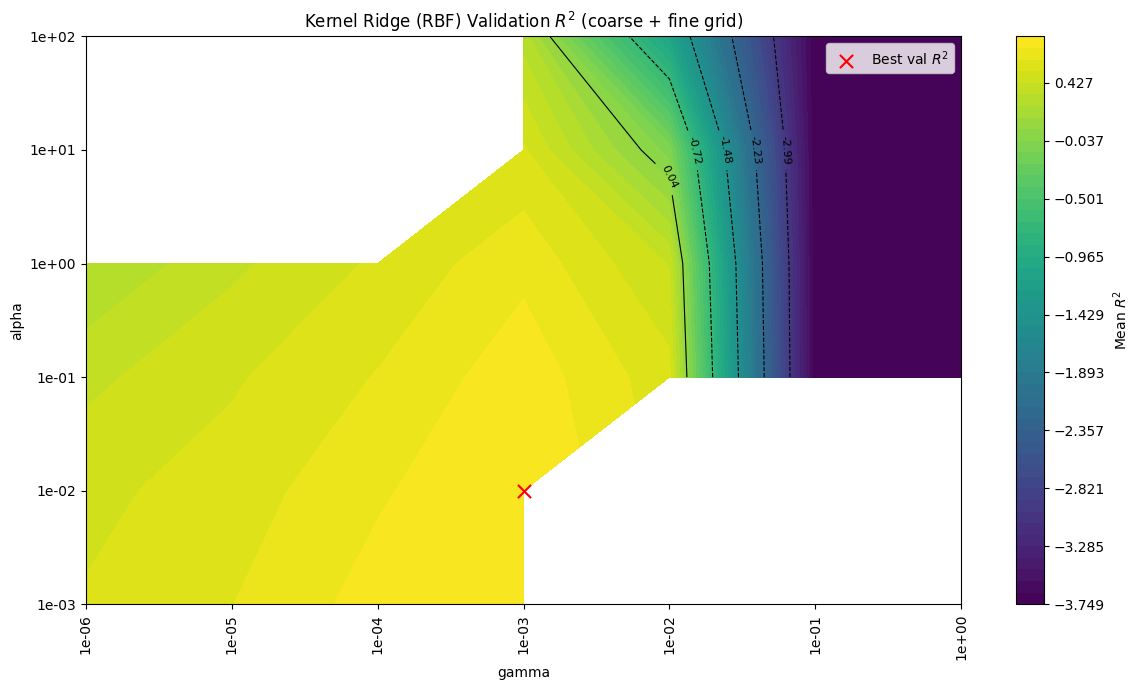

In [40]:
# ---- Combined contour plot (coarse + fine pickles) for Kernel Ridge (RBF) ----
# Loads BOTH: krr_rbf_results.pkl and krr_rbf_results_fine.pkl, merges, then contours Val R^2.

import pickle
import numpy as np
import matplotlib.pyplot as plt

# 1) Load and combine results
with open("krr_rbf_results.pkl", "rb") as f:
    results_coarse = pickle.load(f)

with open("krr_rbf_results_fine.pkl", "rb") as f:
    results_fine = pickle.load(f)

results_all = list(results_coarse) + list(results_fine)

# 2) Build unified gamma/alpha grids from all results
gammas_all = sorted({row["gamma"] for row in results_all})
alphas_all = sorted({row["alpha"] for row in results_all})

gamma_to_j = {g: j for j, g in enumerate(gammas_all)}
alpha_to_i = {a: i for i, a in enumerate(alphas_all)}

# 3) If there are duplicate (alpha,gamma) entries, average them
val_bins = [[[] for _ in gammas_all] for _ in alphas_all]
train_bins = [[[] for _ in gammas_all] for _ in alphas_all]

for row in results_all:
    i = alpha_to_i[row["alpha"]]
    j = gamma_to_j[row["gamma"]]
    val_bins[i][j].append(float(row["r2_val"]))
    train_bins[i][j].append(float(row["r2_train"]))

r2_val_grid = np.full((len(alphas_all), len(gammas_all)), np.nan, dtype=float)
r2_train_grid = np.full((len(alphas_all), len(gammas_all)), np.nan, dtype=float)

for i in range(len(alphas_all)):
    for j in range(len(gammas_all)):
        if val_bins[i][j]:
            r2_val_grid[i, j] = float(np.mean(val_bins[i][j]))
        if train_bins[i][j]:
            r2_train_grid[i, j] = float(np.mean(train_bins[i][j]))

# 4) Plot contour (Validation by default)
Z = r2_val_grid  # change to r2_train_grid for train contour

XX, YY = np.meshgrid(np.arange(len(gammas_all)), np.arange(len(alphas_all)))

vmin = float(np.nanmin(Z))
vmax = float(np.nanmax(Z))
levels_f = np.linspace(vmin, vmax, 50)

plt.figure(figsize=(12, 7))
plt.contourf(XX, YY, Z, levels=levels_f, cmap="viridis")
plt.colorbar(label="Mean $R^2$")

levels_c = np.linspace(vmin, vmax, 7)
CS = plt.contour(XX, YY, Z, levels=levels_c, colors="k", linewidths=0.8)
plt.clabel(CS, CS.levels, inline=True, fontsize=8, fmt="%.2f")

plt.title("Kernel Ridge (RBF) Validation $R^2$ (coarse + fine grid)")
plt.xlabel("gamma")
plt.ylabel("alpha")

plt.xticks(np.arange(len(gammas_all)), [f"{g:.0e}" for g in gammas_all], rotation=90)
plt.yticks(np.arange(len(alphas_all)), [f"{a:.0e}" for a in alphas_all])

# Mark best point (highest validation R^2)
best_idx = np.nanargmax(r2_val_grid)
best_i, best_j = np.unravel_index(best_idx, r2_val_grid.shape)
plt.scatter(best_j, best_i, c="red", s=90, marker="x", label="Best val $R^2$")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Best params from saved sweeps:
  gamma = 0.001
  alpha = 0.01
  sweep val R^2 = 0.7977

Test mean R^2 (uniform average): 0.6798
Test per-joint R^2:
  Thumb_Roll      :  0.6340
  Thumb_Inner     :  0.5656
  Thumb_Outer     :  0.5635
  TI_Abduction    :  0.6207
  Index_Inner     :  0.6483
  Index_Middle    :  0.6457
  Middle_Inner    :  0.7187
  Middle_Middle   :  0.7268
  MI_Abduction    :  0.7002
  Ring_Inner      :  0.7451
  Ring_Middle     :  0.7650
  RM_Abduction    :  0.5402
  Pinky_Inner     :  0.7445
  Pinky_Middle    :  0.7127
  PR_Abduction    :  0.7334
  Palm_Arch       :  0.7396
  Wrist_Flex      :  0.7640
  Wrist_Abduction :  0.6690


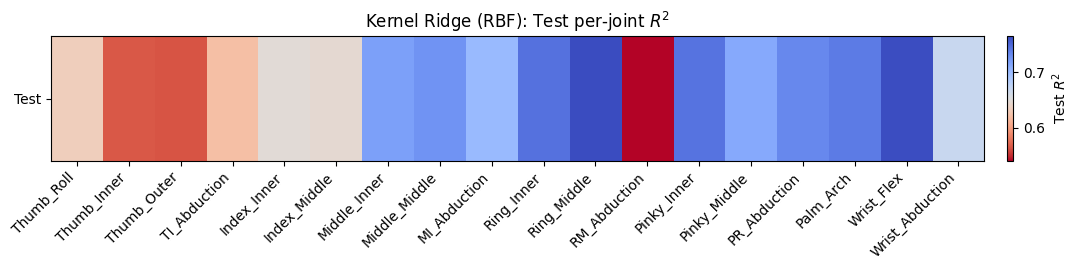

In [ ]:
# ---- KRR (RBF): load best params -> train on ALL train -> test -> per-joint R^2 heatmap ----
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Uses the joint_names array already defined in this notebook (from the PER JOINT heatmap section)
joint_names = [
    "Thumb_Roll", "Thumb_Inner", "Thumb_Outer", "TI_Abduction",
    "Index_Inner", "Index_Middle", "Middle_Inner", "Middle_Middle",
    "MI_Abduction", "Ring_Inner", "Ring_Middle", "RM_Abduction",
    "Pinky_Inner", "Pinky_Middle", "PR_Abduction", "Palm_Arch",
    "Wrist_Flex", "Wrist_Abduction",
]

# Sanity: make sure you already ran the earlier cells that create these
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    dataset["windows_feature"],
    dataset["joints"],
    test_size=0.2,
    random_state=42,
)

X_train_full, y_train_full = reshape_data_windows_regression(X_train_full, y_train_full)
X_test_full, y_test_full = reshape_data_windows_regression(X_test_full, y_test_full)

# 1) Load results and select best hyperparameters by validation R^2
results_all = []
for fname in ["krr_rbf_results.pkl", "krr_rbf_results_fine.pkl"]:
    if os.path.exists(fname):
        with open(fname, "rb") as f:
            results_all.extend(list(pickle.load(f)))
    else:
        print(f"Warning: {fname} not found in current working directory")

if not results_all:
    raise FileNotFoundError(
        "No results loaded. Expected krr_rbf_results.pkl and/or krr_rbf_results_fine.pkl in this folder."
    )

best = max(results_all, key=lambda row: float(row["r2_val"]))
best_gamma = float(best["gamma"])
best_alpha = float(best["alpha"])
print("Best params from saved sweeps:")
print(f"  gamma = {best_gamma:.6g}")
print(f"  alpha = {best_alpha:.6g}")
print(f"  sweep val R^2 = {float(best['r2_val']):.4f}")

# 2) Train on ALL training data (scale fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

model = KernelRidge(alpha=best_alpha, kernel="rbf", gamma=best_gamma)
model.fit(X_train_scaled, y_train_full)

# 3) Test on testing data
y_test_pred = model.predict(X_test_scaled)

r2_test_per_joint = r2_score(y_test_full, y_test_pred, multioutput="raw_values")
r2_test_mean = float(r2_score(y_test_full, y_test_pred, multioutput="uniform_average"))

print(f"\nTest mean R^2 (uniform average): {r2_test_mean:.4f}")
print("Test per-joint R^2:")
for name, val in zip(joint_names, r2_test_per_joint):
    print(f"  {name:16s}: {float(val): .4f}")

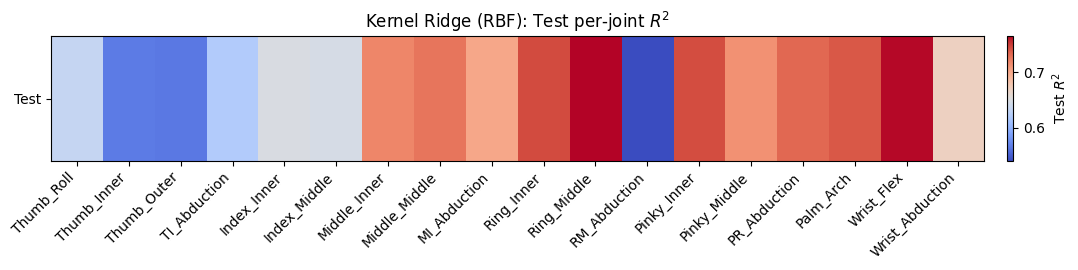

In [10]:
# 4) Plot heatmap for per-joint test R^2
Z = r2_test_per_joint.reshape(1, -1)  # shape (1, 18)

vmin = float(np.nanmin(Z))
vmax = float(np.nanmax(Z))
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax) if (vmin < 0 < vmax) else None

fig, ax = plt.subplots(figsize=(12, 2.8))
im = ax.imshow(
    Z,
    aspect="auto",
    interpolation="nearest",
    cmap="coolwarm",  # red=bad (low), blue=good (high)
    norm=norm,
    vmin=None if norm is not None else vmin,
    vmax=None if norm is not None else vmax,
)

ax.set_title("Kernel Ridge (RBF): Test per-joint $R^2$")
ax.set_yticks([0])
ax.set_yticklabels(["Test"])
ax.set_xticks(np.arange(len(joint_names)))
ax.set_xticklabels(joint_names, rotation=45, ha="right")

cbar = fig.colorbar(im, ax=ax, pad=0.02)
cbar.set_label("Test $R^2$")

plt.tight_layout()
plt.show()